# Evaluation Metrics for Classification 

How do we know model is good or not?

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('Churn_data.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [3]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [4]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

# train the model on train dataset
dv = DictVectorizer(sparse=False)
train_dict = df_train[categorical + numerical].to_dict(orient = 'records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver = 'lbfgs')
model.fit(X_train, y_train) 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [5]:
# evaluate model on validation dataset
val_dict = df_val[categorical + numerical].to_dict(orient = 'records')
X_val = dv.fit_transform(val_dict)

y_pred = model.predict_proba(X_val)[:,1]
t = 0.5
churn_decision = (y_pred >= t).astype(int)
accuracy = (y_val == churn_decision).mean()

In [6]:
accuracy

0.8034066713981547

# Accuracy and Dummy Model

* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines

In [7]:
thresholds = np.linspace(0,1, 20)
scores = []
for t in thresholds:
    score = (y_val == (y_pred>=t)).mean()
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.515
0.11 0.605
0.16 0.671
0.21 0.718
0.26 0.744
0.32 0.763
0.37 0.774
0.42 0.788
0.47 0.796
0.53 0.801
0.58 0.805
0.63 0.792
0.68 0.773
0.74 0.752
0.79 0.735
0.84 0.726
0.89 0.726
0.95 0.726
1.00 0.726


In [8]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val, y_pred>=0.5)

0.8034066713981547

In [9]:
thresholds = np.linspace(0,1, 20)
scores = []
for t in thresholds:
    #score = (y_val == (y_pred>=t)).mean()
    score = accuracy_score(y_val, y_pred>=t)
    
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.515
0.11 0.605
0.16 0.671
0.21 0.718
0.26 0.744
0.32 0.763
0.37 0.774
0.42 0.788
0.47 0.796
0.53 0.801
0.58 0.805
0.63 0.792
0.68 0.773
0.74 0.752
0.79 0.735
0.84 0.726
0.89 0.726
0.95 0.726
1.00 0.726


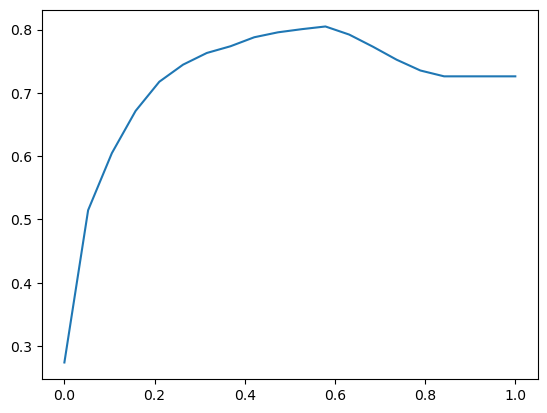

In [10]:
plt.plot(thresholds, scores)

In [11]:
# Counter method from collections module
from collections import Counter
Counter(y_pred >= 1.0)

Counter({False: 1409})

In [12]:
1 - y_val.mean()

0.7260468417317246

# Confusion Table:

In [13]:

actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [14]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

# Precision and recall

In [15]:
p = tp/(fp+tp)
p

0.6752411575562701

In [16]:
r = tp/(fn+tp)
r

0.5440414507772021

# Receiver Operating Character(ROC) Curve:

### TPR and FPR

In [17]:
tpr = tp/(tp+fn)
tpr

0.5440414507772021

In [18]:
fpr = fp/(fp+tn)
fpr

0.09872922776148582

In [19]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [20]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns = columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

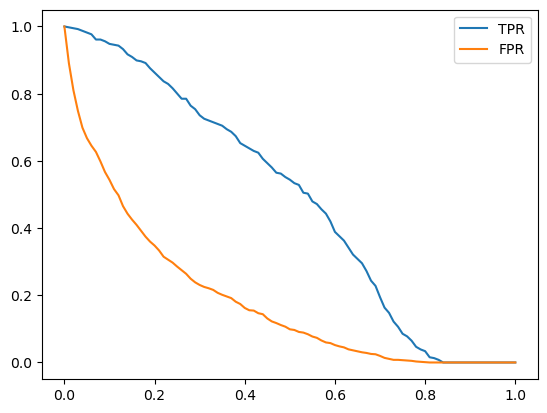

In [21]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

# Random Model

In [32]:
np.random.seed(1)
y_rand = np.random.uniform(0,1, size = len(y_val))

((y_rand >= 0.5).astype(int) == y_val).mean()

0.5017743080198722

In [33]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [34]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

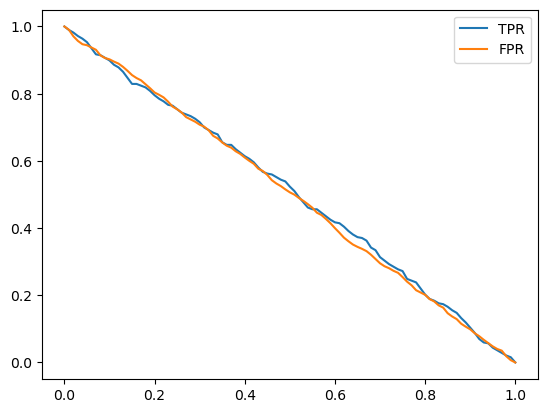

In [35]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

# Ideal Model

In [36]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal_pred = np.linspace(0, 1, len(y_val))
y_ideal_pred.round(3)

array([0.   , 0.001, 0.001, ..., 0.999, 0.999, 1.   ])

In [37]:
1 - y_val.mean()

0.7260468417317246

In [38]:
accuracy_score(y_ideal, y_ideal_pred >= 0.726)

1.0

In [39]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


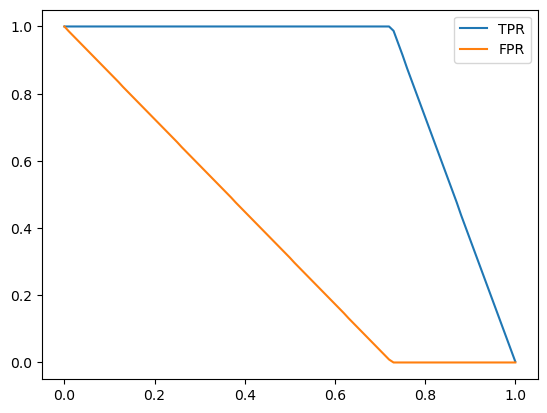

In [40]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

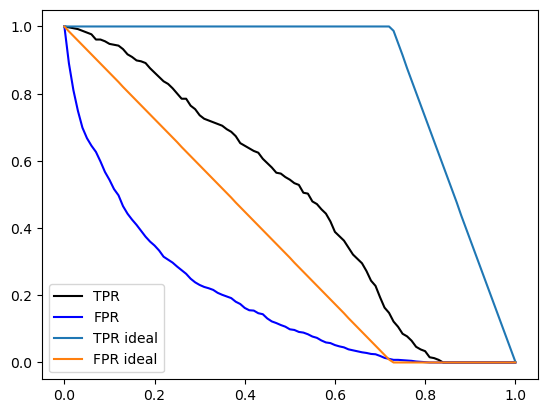

In [41]:
### put everything together

plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

#plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR random', color='grey')
#plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR random', color='grey')

plt.legend()

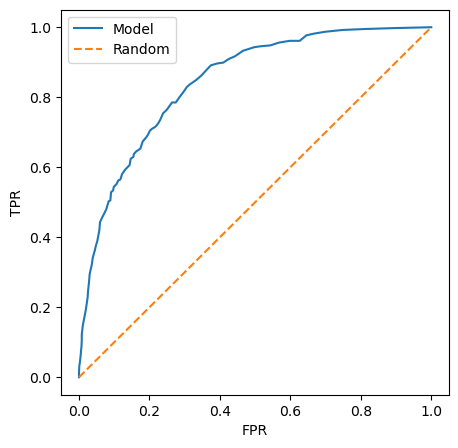

In [42]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

In [ ]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

# ROC AUC
* Area under the ROC curve - useful metric
* Interpretation of AUC

In [ ]:
from sklearn.metrics import auc

In [ ]:
auc(fpr,tpr)

In [ ]:
auc(df_scores.fpr, df_scores.tpr)

In [ ]:
auc(df_ideal.fpr, df_ideal.tpr)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_score(y_val, y_pred)

In [42]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

import random

n = 100000
success = 0 

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n

0.84463

In [43]:
n = 50000

np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

0.84656